# Import libraries

In [34]:
%pip install higra

In [18]:
import numpy as np
import torch as tc
import higra as hg
import torch.nn.functional as F
import math
import cv2
import imageio
import os
from torch.nn import Module
from torch.autograd import Function
import matplotlib.pyplot as plt

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

# Differentiable component trees

Component trees are based on the decomposition of the level sets of a vertex valued graph into connected components. Each connected component can be associated to an altitude which is equal to the level of the first level set where the component appears. The altitude of a component is thus equal to the value of some vertices of the graph. We can then back-propagate a modification of the tree altitudes to the original vertex values.   

The following functions implement component-trees (max-tree, min-tree, and tree-of-shapes) as Pytorch functions where the altitudes of the tree are differentiable with respect to the vertex values of the input graph.

In [19]:
class ComponentTreeFunction(Function):
    @staticmethod
    def forward(ctx, graph, vertex_weights, tree_type="max", plateau_derivative="full"):
        """
        Construct a component tree of the given vertex weighted graph.

        tree_type must be in ("min", "max", "tos")

        plateau_derivative can be "full" or "single". In the first case, the gradient of an altitude component
        is back-propagated to the vertex weights of the whole plateau (to all proper vertices of the component).
        In the second case, an arbitrary vertex of the plateau is selected and will receive the gradient.

        return: the altitudes of the tree (torch tensor), the tree itself is stored as an attribute of the tensor
        """
        if tree_type == "max":
            tree, altitudes = hg.component_tree_max_tree(graph, vertex_weights.detach().numpy())
        elif tree_type == "min":
            tree, altitudes = hg.component_tree_min_tree(graph, vertex_weights.detach().numpy())
        elif tree_type == "tos":
            tree, altitudes = hg.component_tree_tree_of_shapes_image2d(vertex_weights.detach().numpy())
        else:
            raise ValueError("Unknown tree type " + str(tree_type))

        if plateau_derivative == "full":
            plateau_derivative = True
        elif plateau_derivative == "single":
            plateau_derivative = False
        else:
            raise ValueError("Unknown plateau derivative type " + str(plateau_derivative))
        ctx.saved = (tree, graph, plateau_derivative)
        altitudes = tc.from_numpy(altitudes).clone().requires_grad_(True)
        # torch function can only return tensors, so we hide the tree as a an attribute of altitudes
        altitudes.tree = tree
        return altitudes

    @staticmethod
    def backward(ctx, grad_output):
        tree, graph, plateau_derivative = ctx.saved
        if plateau_derivative:
            grad_in = grad_output[tree.parents()[:tree.num_leaves()]]
        else:
            leaf_parents = tree.parents()[:tree.num_leaves()]
            _, indices = np.unique(leaf_parents, return_index=True)
            grad_in = tc.zeros((tree.num_leaves(),), dtype=grad_output.dtype)
            grad_in[indices] = grad_output[leaf_parents[indices]]
        return None, hg.delinearize_vertex_weights(grad_in, graph), None

class ComponentTree(Module):
    def __init__(self, tree_type):
        super().__init__()
        tree_types = ("max", "min", "tos")
        if tree_type not in tree_types:
            raise ValueError("Unknown tree type " + str(tree_type) + " possible values are " + " ".join(tree_types))

        self.tree_type = tree_type

    def forward(self, graph, vertex_weights):
        altitudes = ComponentTreeFunction.apply(graph, vertex_weights, self.tree_type)
        return altitudes.tree, altitudes

max_tree = ComponentTree("max")
min_tree = ComponentTree("min")
tos_tree = ComponentTree("tos")

# Definition of a utility Optimizer class

This is a simple class to perform gradient descent based optimization with pytorch.

In [20]:
class Optimizer:
    def __init__(self, loss, lr, optimizer="adam", erosion=False):
        """
        Create an Optimizer utility object

        loss: function that takes a single torch tensor which support requires_grad = True and returns a torch scalar
        lr: learning rate
        optimizer: "adam" or "sgd"
        """
        self.loss_function = loss
        self.history = []
        self.optimizer = optimizer
        self.lr = lr
        self.best = None
        self.best_loss = float("inf")
        self.erosion = erosion

        # added
        self.images = []
        self.delete_label = []
        self.keep_label = []
        self.connect_label = []

    def fit(self, data, iter=1000, debug=False, min_lr=1e-6):
        """
        Fit the given data

        data: torch tensor, input data
        iter: int, maximum number of iterations
        debug: int, if > 0, print current loss value and learning rate every debug iterations
        min_lr: float, minimum learning rate (an LR scheduler is used), if None, no LR scheduler is used
        """
        self.images.append(data.clone().detach().numpy())
        _, delete, keep, connect = self.loss_function(tc.relu(data))

        data = data.clone().requires_grad_(True)
        if self.optimizer == "adam":
            optimizer = tc.optim.Adam([data], lr=self.lr, amsgrad=True)
        else:
            optimizer = tc.optim.SGD([data], lr=self.lr)

        if min_lr:
            lr_scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=100)

        for t in range(iter):
            optimizer.zero_grad()
            if self.erosion == True:
                loss, delete, keep, connect = self.loss_function(tc.relu(data))
                kernel = tc.ones(1, 1, 5, 5).to(data.device)
                eroded_data = F.conv2d(data.unsqueeze(0).unsqueeze(0).to(tc.double), kernel.to(tc.double), padding=(kernel.size(2) - 1) // 2).squeeze().float()
                loss, delete, keep, connect = self.loss_function(tc.relu(eroded_data))
            else:
                loss, delete, keep, connect = self.loss_function(tc.relu(data))

            loss.backward()
            optimizer.step()
            loss_value = loss.item()

            self.images.append(data.clone().detach().numpy())
            self.delete_label.append(delete)
            self.keep_label.append(keep)
            self.connect_label.append(connect)

            self.history.append(loss_value)
            if loss_value < self.best_loss:
                self.best_loss = loss_value
                self.best = tc.relu(data).clone()

            if min_lr:
                lr_scheduler.step(loss_value)
                if optimizer.param_groups[0]['lr'] <= min_lr:
                    break

            if debug and t % debug == 0:
                print("Iteration {}: Loss: {:.4f}, LR: {}".format(t, loss_value, optimizer.param_groups[0]['lr']))
        return self.best

    def show_history(self):
        """
        Plot loss history
        """
        plt.plot(self.history)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()

    def get_images_per_iter(self):
        return self.images

    def get_delete_label_per_iter(self):
        return self.delete_label

    def get_keep_label_per_iter(self):
        return self.keep_label

    def get_connect_label_per_iter(self):
        return self.connect_label

# Definition of test data

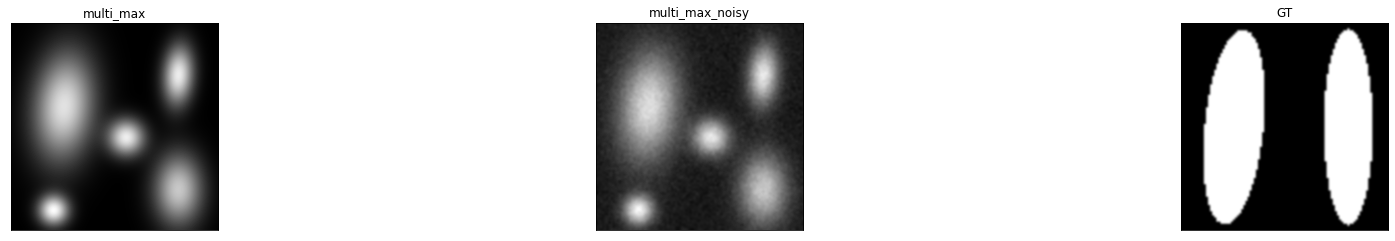

In [21]:
testimage = {}
np.random.seed(42)

def draw_Gaussian_2d(im, x0, y0, sigma_X, sigma_Y, theta, A):
    """
    Draw a 2d gaussian in the buffer image im at position (x0, y0), with
    standard deviation sigma_X and sigma_Y, a rotation of theta, and a central
    brightness equal to A.
    """

    X, Y = np.meshgrid(np.arange(im.shape[0]), np.arange(im.shape[1]))

    a = np.cos(theta)**2/(2*sigma_X**2) + np.sin(theta)**2/(2*sigma_Y**2)
    b = -np.sin(2*theta)/(4*sigma_X**2) + np.sin(2*theta)/(4*sigma_Y**2)
    c = np.sin(theta)**2/(2*sigma_X**2) + np.cos(theta)**2/(2*sigma_Y**2)

    Z = A*np.exp( - (a*(X-x0)**2 + 2*b*(X-x0)*(Y-y0) + c*(Y-y0)**2))

    im += Z


def gen_multi_max(noise):
    """
    Create a test image with 4 maxima of various sizes and brightnesses
    """
    im = np.zeros((100, 100))
    draw_Gaussian_2d(im, 25, 40, 10, 18, -0.1, 1.8)
    draw_Gaussian_2d(im, 20, 90, 5, 5, 0, 2)
    draw_Gaussian_2d(im, 55, 55, 6, 6, 0.1, 1.9)
    draw_Gaussian_2d(im, 80, 25, 10, 5, 1.5, 1.9)
    draw_Gaussian_2d(im, 80, 80, 8, 12, 0, 1.6)

    im = im / im.max()
    if noise > 0:
        im = im + np.random.randn(*im.shape) * noise
        im = im / im.max()
    return im


def gen_multi_max_gt(noise):
    im = np.zeros((100, 100))
    draw_Gaussian_2d(im, 25, 50, 12, 40, -0.1, 1)
    draw_Gaussian_2d(im, 80, 50, 10, 40, 0, 1)

    im = im / im.max()
    if noise > 0:
        im = im + np.random.randn(*im.shape) * noise
        im = im / im.max()
    return im

testimage["multi_max"] = gen_multi_max(noise=0)
testimage["multi_max_noisy"] = gen_multi_max(noise=0.03)
testimage["GT"] = gen_multi_max_gt(noise=0)

image = testimage["GT"]
image = cv2.convertScaleAbs(image)
_, binary_image_gt = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

testimage["GT"] = binary_image_gt

figsize = 5
fig = plt.figure(figsize=(figsize * figsize, len(testimage)))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
def plot_im(rows, columns, y, x, im, title):
    plt.subplot(rows, columns, y * columns + x + 1);
    plt.imshow(im, interpolation="bicubic", cmap="gray");
    plt.xticks([]); plt.yticks([])
    plt.title(title)

testdata = {}
for i, (k, im) in enumerate(testimage.items()):
    testdata[k] = (hg.get_8_adjacency_implicit_graph(im.shape), im)
    plot_im(1, len(testimage), 0, i, im, k)

# Maxima loss based on extinction values

We first define to auxiliary function used in the computation of extinction values associated to the nodes of a hierarchy.

The main function is attribute_saddle_node, which for any increasing attribute value, identifies for each node n, the closest ancestor of n, called saddle node, which contains a descendent having an attribute value greater than the attribute value of any descendent of n.

Finally, the following loss function will try to enforce the presence of a prescribed number of maxima in the given image based on the given saliency and importance maxima measures.

In [22]:
def attribute_depth(tree, altitudes):
    """
    Compute the depth of any node of the tree which is equal to the largest altitude
    in the subtree rooted in the current node.

    :param tree: input tree
    :param altitudes: np array (1d), altitudes of the input tree nodes
    :return: np array (1d), depth of the tree nodes
    """
    return hg.accumulate_sequential(tree, altitudes[:tree.num_leaves()], hg.Accumulators.max)

def attribute_saddle_nodes(tree, attribute):
    """
    Let n be a node and let an be an ancestor of n. The node an has a single child node that contains n denoted by ch(an -> n).
    The saddle and base nodes associated to a node n for the given attribute values are respectively the closest ancestor an
    of n and the node ch(an -> n) such that there exists a child c of an with attr(ch(an -> n)) < attr(c).

    :param tree: input tree
    :param attribute: np array (1d), attribute of the input tree nodes
    :return: (np array, np array), saddle and base nodes of the input tree nodes for the given attribute
    """
    max_child_index = hg.accumulate_parallel(tree, attribute, hg.Accumulators.argmax)
    child_index = hg.attribute_child_number(tree)
    main_branch = child_index == max_child_index[tree.parents()]
    main_branch[:tree.num_leaves()] = True

    saddle_nodes = hg.propagate_sequential(tree, np.arange(tree.num_vertices())[tree.parents()], main_branch)
    base_nodes = hg.propagate_sequential(tree, np.arange(tree.num_vertices()), main_branch)
    return saddle_nodes, base_nodes

### New importance "dice"

In [23]:
def attribute_dice(image_gt, image, tree):
    nbGTPix = image_gt.sum()
    areaNodes = hg.attribute_area(tree)
    gt = np.reshape(image_gt,len(image_gt))
    image = np.reshape(image,len(image))
    att = hg.accumulate_sequential(tree, (image != 0) & (gt != 0), hg.Accumulators.sum)
    union = nbGTPix + areaNodes
    dice = 2 * att / union
    return hg.accumulate_and_max_sequential(tree,  dice, dice[:len(image_gt)], hg.Accumulators.max)

# Multi-Factor Component Tree Loss Function

In [24]:
def loss_maxima(graph, image, image_gt, saliency_measure, importance_measure, margin=1, p=1, erosion=False):
    tree, altitudes = max_tree(graph, image)
    altitudes_np = altitudes.detach().numpy()

    extrema = hg.attribute_extrema(tree, altitudes_np)
    extrema_indices = np.arange(tree.num_vertices())[extrema]
    extrema_altitudes = altitudes[tc.from_numpy(extrema_indices).long()]

    if importance_measure == "area":
        area = hg.attribute_area(tree)
        pass_nodes, base_nodes = attribute_saddle_nodes(tree, area)
        extrema_area = tc.from_numpy(area[base_nodes[extrema_indices]])

    if importance_measure == "volume":
        volume = hg.attribute_volume(tree, altitudes_np)
        pass_nodes, base_nodes = attribute_saddle_nodes(tree, volume)
        extrema_volume = tc.from_numpy(volume[base_nodes[extrema_indices]])

    saliency = []
    if saliency_measure[0] == "altitude" and saliency_measure[1] == "connect":
        depth = attribute_depth(tree, altitudes_np)
        saddle_nodes = tc.from_numpy(attribute_saddle_nodes(tree, depth)[0]).long()
        if erosion == True:
            extrema_connect = 99 - altitudes[saddle_nodes[extrema_indices]]
        else:
            extrema_connect = 1 - altitudes[saddle_nodes[extrema_indices]]
        saliency.append(extrema_altitudes)
        saliency.append(extrema_connect)

    if importance_measure == "altitude":
        importance = extrema_altitudes
    elif importance_measure == "dynamics":
        depth = attribute_depth(tree, altitudes_np)
        saddle_nodes = tc.from_numpy(attribute_saddle_nodes(tree, depth)[0])
        extrema_dynamics = extrema_altitudes - altitudes[saddle_nodes[extrema_indices].long()]
        importance = extrema_dynamics
    elif importance_measure == "area":
        importance = extrema_area
    elif importance_measure == "volume":
        importance = extrema_volume

    elif importance_measure == "dice":
        image_gt = image_gt.reshape(100*100, 1)
        image = image.detach().numpy().reshape(100*100, 1)
        dice = attribute_dice(image_gt, image, tree)
        extinction_value = hg.attribute_extinction_value(tree, altitudes_np, np.array(dice))
        importance = [tc.tensor(extinction_value[i]) for i in extrema_indices]

    G1 = []
    G2 = []
    G3 = []

    delete_label = np.zeros((100, 100)).flatten()
    keep_label = np.zeros((100, 100)).flatten()
    connect_label = np.zeros((100, 100)).flatten()

    for i, ext_idx in enumerate(extrema_indices):
        if importance[i] == 0:
            G1.append(i)
            for child in tree.children(ext_idx):
                delete_label[child] = extrema_altitudes[i]
        elif importance[i] >= 0.7:
            G2.append(i)
            for child in tree.children(ext_idx):
                keep_label[child] = extrema_altitudes[i]
        else:
            G3.append(i)
            for child in tree.children(ext_idx):
                connect_label[child] = extrema_altitudes[i]


    delete_label = delete_label.reshape((100, 100))
    keep_label = keep_label.reshape((100, 100))
    connect_label = connect_label.reshape((100, 100))

    return tc.sum(saliency[0][G1]**p) + tc.sum(tc.relu(margin - saliency[0][G2])**p) + tc.sum(saliency[1][G3]**p), delete_label, keep_label, connect_label

# Experiment

In [25]:
def save_results_to_folder(results, folder_path, iteration):
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    # Save each result in the folder
    for i, result in enumerate(results):
        filename = os.path.join(folder_path, f'iteration_{iteration}.png')
        np.save(filename, result)

In [26]:
def plot_im(rows, columns, y, x, im, title):
    plt.subplot(rows, columns, y * columns + x + 1)
    plt.imshow(im, interpolation="bicubic", cmap="gray", vmax=1, vmin=0)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

(-0.5, 99.5, 99.5, -0.5)

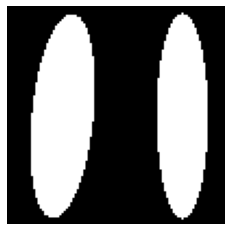

In [27]:
image_gt = testimage["GT"]
plt.imshow(image_gt, cmap="gray")
plt.axis("off")

(-0.5, 99.5, 99.5, -0.5)

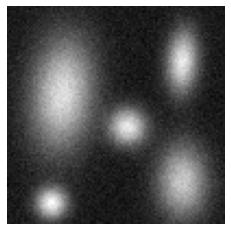

In [28]:
graph, image = testdata["multi_max_noisy"]
plt.imshow(image, cmap="gray")
plt.axis("off")

CPU times: total: 0 ns
Wall time: 0 ns
Iteration 0: Loss: 179.3395, LR: 0.001


Iteration 300: Loss: 12.1017, LR: 0.001
Iteration 600: Loss: 13.9376, LR: 0.001
Iteration 900: Loss: 9.6262, LR: 0.001
Iteration 1200: Loss: 9.8032, LR: 0.001
Iteration 1500: Loss: 7.6598, LR: 0.001
Iteration 1800: Loss: 1.6243, LR: 0.001
Iteration 2100: Loss: 2.9683, LR: 0.001
Iteration 2400: Loss: 2.0005, LR: 0.001
Iteration 2700: Loss: 2.0007, LR: 0.001
Total time:  54.33140563964844


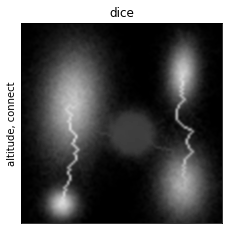

In [29]:
# Assuming 'img' is a NumPy array that you want to convert to a PyTorch tensor
%time
import time
image_arr = []
image_gt = testimage["GT"]
graph, image = testdata["multi_max_noisy"]

saliency_measures = [["altitude", "connect"]]
importance_measures = ["dice"]

fig = plt.figure(figsize=(3 * 3, 3 * 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

def loss(image):
    return loss_maxima(graph, image, image_gt, sm, im, margin=1, p=1, erosion=False)

start_time = time.time()
for i, sm in enumerate(saliency_measures):
    for j, im in enumerate(importance_measures):
        opt = Optimizer(loss, lr=0.001)
        opt.fit(tc.from_numpy(image.copy()).to(tc.float32), iter=3000, min_lr=None, debug=300)
        res = opt.best.detach().numpy()
        images = opt.get_images_per_iter()
        delete = opt.get_delete_label_per_iter()
        keep = opt.get_keep_label_per_iter()
        connect = opt.get_connect_label_per_iter()
        f = plt.subplot(3, 3, i * 3 + j + 1)
        plt.imshow(res, interpolation="bicubic", cmap="gray")
        plt.xticks([])
        plt.yticks([])
        if j == 0:
            f.set_ylabel("altitude, connect")
        if i == 0:
            f.set_title("dice")
end_time = time.time()
print("Total time: ", end_time - start_time)

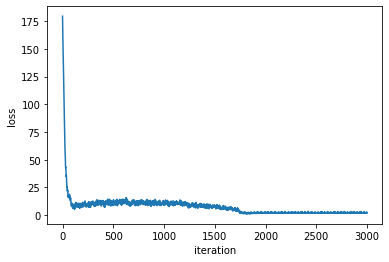

In [30]:
opt.show_history()

# Thickening the connection paths

CPU times: total: 0 ns
Wall time: 0 ns
Iteration 0: Loss: 692.4929, LR: 0.001
Iteration 300: Loss: 751.9960, LR: 0.001
Iteration 600: Loss: 700.4240, LR: 0.001
Iteration 900: Loss: 895.5825, LR: 0.001
Iteration 1200: Loss: 188.6194, LR: 0.001
Iteration 1500: Loss: 198.0068, LR: 0.001
Iteration 1800: Loss: 188.6279, LR: 0.001
Iteration 2100: Loss: 198.0083, LR: 0.001
Iteration 2400: Loss: 207.4910, LR: 0.001
Iteration 2700: Loss: 207.5837, LR: 0.001
Total time:  166.03191208839417


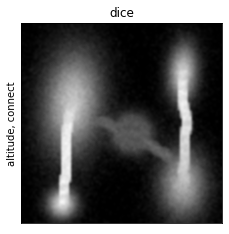

In [31]:
# Assuming 'img' is a NumPy array that you want to convert to a PyTorch tensor
%time
import time
image_arr = []
image_gt = testimage["GT"]
graph, image = testdata["multi_max_noisy"]

saliency_measures = [["altitude", "connect"]]
importance_measures = ["dice"]

fig = plt.figure(figsize=(3 * 3, 3 * 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

def loss(image):
    return loss_maxima(graph, image, image_gt, sm, im, margin=1, p=1, erosion=True)

start_time = time.time()
for i, sm in enumerate(saliency_measures):
    for j, im in enumerate(importance_measures):
        opt = Optimizer(loss, lr=0.001, erosion=True)
        opt.fit(tc.from_numpy(image.copy()).to(tc.float32), iter=3000, min_lr=None, debug=300)
        res = opt.best.detach().numpy()
        images = opt.get_images_per_iter()
        delete = opt.get_delete_label_per_iter()
        keep = opt.get_keep_label_per_iter()
        connect = opt.get_connect_label_per_iter()
        f = plt.subplot(3, 3, i * 3 + j + 1)
        plt.imshow(res, interpolation="bicubic", cmap="gray")
        plt.xticks([])
        plt.yticks([])
        if j == 0:
            f.set_ylabel("altitude, connect")
        if i == 0:
            f.set_title("dice")
end_time = time.time()
print("Total time: ", end_time - start_time)

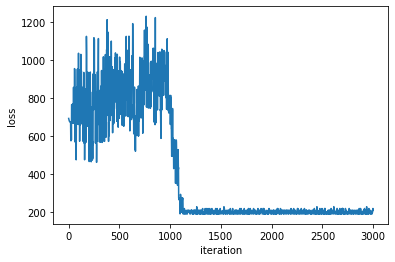

In [32]:
opt.show_history()